In [ ]:
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import gridspec
import pandas as pd
import numpy as np

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

Brown (2019): https://github.com/IrinaStatsLab/Awesome-CGM/wiki/Brown-(2019)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
file_path = '/content/drive/My Drive/TÜ Andmeteadus MSc/Machine Learning I/Project/cgm.txt'
dclp3 = pd.read_csv(file_path, sep="|")

In [ ]:
# dclp3 = pd.read_csv("C:/Users/meril/Desktop/Projekt_ML/DCLP3/Data Files/cgm.txt", sep="|")

In [ ]:
dclp3.head(10)

,PtID,Period,DataDtTm,CGM
0,1,1. Baseline,11DEC17:23:59:25,172
1,1,1. Baseline,12DEC17:00:04:24,170
2,1,1. Baseline,12DEC17:00:09:24,167
3,1,1. Baseline,12DEC17:00:14:25,163
4,1,1. Baseline,12DEC17:00:19:25,160
5,1,1. Baseline,12DEC17:00:24:24,158
6,1,1. Baseline,12DEC17:00:29:25,157
7,1,1. Baseline,12DEC17:00:34:25,155
8,1,1. Baseline,12DEC17:00:39:24,154
9,1,1. Baseline,12DEC17:00:44:25,153


In [ ]:
# Format dates from string to datetime
dclp3['DataDtTm'] = pd.to_datetime(dclp3['DataDtTm'], format='%d%b%y:%H:%M:%S')

In [ ]:
dclp3.head()

,PtID,Period,DataDtTm,CGM
0,1,1. Baseline,2017-12-11 23:59:25,172
1,1,1. Baseline,2017-12-12 00:04:24,170
2,1,1. Baseline,2017-12-12 00:09:24,167
3,1,1. Baseline,2017-12-12 00:14:25,163
4,1,1. Baseline,2017-12-12 00:19:25,160


In [ ]:
# Extract date from 'DataDtTm' and sort
dclp3['date'] = dclp3['DataDtTm'].dt.date
dclp3 = dclp3.sort_values(['PtID', 'DataDtTm'])

# Extract time from 'DataDtTm' and sort
dclp3['time'] = dclp3['DataDtTm'].dt.time
dclp3['hour'] = dclp3['DataDtTm'].dt.hour
dclp3 = dclp3.sort_values(['PtID', 'DataDtTm'])

# Calculate the time difference between two events
dclp3['delta_min'] = dclp3.groupby('PtID')['DataDtTm'].diff().dt.total_seconds() / 60

In [ ]:
dclp3.head(10)

,PtID,Period,DataDtTm,CGM,date,time,hour,delta_min
0,1,1. Baseline,2017-12-11 23:59:25,172,2017-12-11,23:59:25,23,NaN
1,1,1. Baseline,2017-12-12 00:04:24,170,2017-12-12,00:04:24,0,4.983333
2,1,1. Baseline,2017-12-12 00:09:24,167,2017-12-12,00:09:24,0,5.000000
3,1,1. Baseline,2017-12-12 00:14:25,163,2017-12-12,00:14:25,0,5.016667
4,1,1. Baseline,2017-12-12 00:19:25,160,2017-12-12,00:19:25,0,5.000000
5,1,1. Baseline,2017-12-12 00:24:24,158,2017-12-12,00:24:24,0,4.983333
6,1,1. Baseline,2017-12-12 00:29:25,157,2017-12-12,00:29:25,0,5.016667
7,1,1. Baseline,2017-12-12 00:34:25,155,2017-12-12,00:34:25,0,5.000000
8,1,1. Baseline,2017-12-12 00:39:24,154,2017-12-12,00:39:24,0,4.983333
9,1,1. Baseline,2017-12-12 00:44:25,153,2017-12-12,00:44:25,0,5.016667


In [ ]:
# Deviation of time into 6 standard time periods (given by supervisor)
def assign_period(hour):
    if 0 <= hour < 3:
        return '00:00–03:00'
    elif 3 <= hour < 9:
        return '03:00–09:00'
    elif 9 <= hour < 12:
        return '09:00–12:00'
    elif 12 <= hour < 17:
        return '12:00–17:00'
    elif 17 <= hour < 21:
        return '17:00–21:00'
    else:
        return '21:00–00:00'

In [ ]:
dclp3['time_period'] = dclp3['hour'].apply(assign_period)

In [ ]:
dclp3.head()

,PtID,Period,DataDtTm,CGM,date,time,hour,delta_min,time_period
0,1,1. Baseline,2017-12-11 23:59:25,172,2017-12-11,23:59:25,23,NaN,21:00–00:00
1,1,1. Baseline,2017-12-12 00:04:24,170,2017-12-12,00:04:24,0,4.983333,00:00–03:00
2,1,1. Baseline,2017-12-12 00:09:24,167,2017-12-12,00:09:24,0,5.000000,00:00–03:00
3,1,1. Baseline,2017-12-12 00:14:25,163,2017-12-12,00:14:25,0,5.016667,00:00–03:00
4,1,1. Baseline,2017-12-12 00:19:25,160,2017-12-12,00:19:25,0,5.000000,00:00–03:00


In [ ]:
# Count missing values at 'CGM'
print("Missing values at column 'CGM': ", dclp3['CGM'].isna().sum())

print("\nSummary of column 'CGM'")
print(dclp3['CGM'].describe())

Missing values at column 'CGM':  0

Summary of column 'CGM'
count    9.032235e+06
mean     1.604207e+02
std      6.120771e+01
min      3.900000e+01
25%      1.160000e+02
50%      1.480000e+02
75%      1.930000e+02
max      4.010000e+02
Name: CGM, dtype: float64


In [ ]:
# Interpolate missing values at column 'CGM'
# dclp3['CGM_interp'] = dclp3.groupby('PtID')['CGM'].transform(lambda x: x.interpolate(limit=3))

# print("\nMissing values at column 'CGM' after interpolation: ", dclp3['CGM'].isna().sum())

# print("\nSummary of column 'CGM' after interpolation")
# print(dclp3['CGM'].describe())

In [ ]:
# Convert mg/dL → mmol/L, because those are the units our supervisor gave us while giving an overview of the topic
dclp3['CGM_mmol'] = dclp3['CGM'] / 18

# Create a column to check if the value of CGM is between 4–10 mmol/L
dclp3['in_range'] = dclp3['CGM_mmol'].between(4, 10)


In [ ]:
dclp3.head()

,PtID,Period,DataDtTm,CGM,date,time,hour,delta_min,time_period,CGM_mmol,in_range
0,1,1. Baseline,2017-12-11 23:59:25,172,2017-12-11,23:59:25,23,NaN,21:00–00:00,9.555556,True
1,1,1. Baseline,2017-12-12 00:04:24,170,2017-12-12,00:04:24,0,4.983333,00:00–03:00,9.444444,True
2,1,1. Baseline,2017-12-12 00:09:24,167,2017-12-12,00:09:24,0,5.000000,00:00–03:00,9.277778,True
3,1,1. Baseline,2017-12-12 00:14:25,163,2017-12-12,00:14:25,0,5.016667,00:00–03:00,9.055556,True
4,1,1. Baseline,2017-12-12 00:19:25,160,2017-12-12,00:19:25,0,5.000000,00:00–03:00,8.888889,True


In [ ]:
# Classify by the CGM_mmol is it in range, hypoglycemia, or hyperglycemia
def classify_glucose(val): # in mmol/L
    if val < 4.0:
        return 'hypoglycemia'
    elif val <= 10:
        return 'in_range'
    else:
        return 'hyperglycemia'

In [ ]:
dclp3['CGM_category'] = dclp3['CGM_mmol'].apply(classify_glucose)

In [ ]:
dclp3.tail(10)

,PtID,Period,DataDtTm,CGM,date,time,hour,delta_min,time_period,CGM_mmol,in_range,CGM_category
4292115,171,2. Post Randomization,2018-10-24 08:25:05,160,2018-10-24,08:25:05,8,5.000000,03:00–09:00,8.888889,True,in_range
4292116,171,2. Post Randomization,2018-10-24 08:30:04,163,2018-10-24,08:30:04,8,4.983333,03:00–09:00,9.055556,True,in_range
4292117,171,2. Post Randomization,2018-10-24 08:35:04,164,2018-10-24,08:35:04,8,5.000000,03:00–09:00,9.111111,True,in_range
4292118,171,2. Post Randomization,2018-10-24 08:40:04,167,2018-10-24,08:40:04,8,5.000000,03:00–09:00,9.277778,True,in_range
4292119,171,2. Post Randomization,2018-10-24 08:45:04,168,2018-10-24,08:45:04,8,5.000000,03:00–09:00,9.333333,True,in_range
4292120,171,2. Post Randomization,2018-10-24 08:50:04,174,2018-10-24,08:50:04,8,5.000000,03:00–09:00,9.666667,True,in_range
4292121,171,2. Post Randomization,2018-10-24 08:55:04,192,2018-10-24,08:55:04,8,5.000000,03:00–09:00,10.666667,False,hyperglycemia
4292122,171,2. Post Randomization,2018-10-24 09:00:04,189,2018-10-24,09:00:04,9,5.000000,09:00–12:00,10.500000,False,hyperglycemia
4292123,171,2. Post Randomization,2018-10-24 09:05:04,183,2018-10-24,09:05:04,9,5.000000,09:00–12:00,10.166667,False,hyperglycemia
4292124,171,2. Post Randomization,2018-10-24 09:10:04,175,2018-10-24,09:10:04,9,5.000000,09:00–12:00,9.722222,True,in_range


In [ ]:
# Selecting patients by rank
def is_in_range_rank(pt_start, pt_end): # in mmol/L

    for pt in range(pt_start, pt_end+1):
        subset = dclp3[dclp3['PtID'] == pt]

        # Time in Range (must be >= 70%)
        TIR = subset['in_range'].mean() * 100

        print(f"Patient no. {pt} Time in Range: {TIR:.1f}%")
        if TIR < 70:
            print("Not in range (<70%)\n")
        elif TIR >= 70:
            print("In range (≥70%)!\n")
        else:
            print("Nan\n")

In [ ]:
# By selecting specific patients
def is_in_range_select(pts): # in mmol/L; pts is a vector

    for pt in pts:
        subset = dclp3[dclp3['PtID'] == pt]

        # Time in Range (must be >= 70%)
        TIR = subset['in_range'].mean() * 100

        print(f"Patient no. {pt} Time in Range: {TIR:.1f}%")
        if TIR < 70:
            print("Not in range (<70%)\n")
        elif TIR >= 70:
            print("In range (≥70%)!\n")
        else:
            print("Nan\n")

In [ ]:
# IMPORTANT: the blood sugar level should be between 4-10 mmol/L 70% of the time
pt_start = 1
pt_end = 1
is_in_range_rank(pt_start, pt_end)

Patient no. 1 Time in Range: 49.5%
Not in range (<70%)



In [ ]:
pts = [0,2,4,6,8,10]
is_in_range_select(pts)

Patient no. 0 Time in Range: nan%
Nan

Patient no. 2 Time in Range: 64.9%
Not in range (<70%)

Patient no. 4 Time in Range: 69.9%
Not in range (<70%)

Patient no. 6 Time in Range: 69.4%
Not in range (<70%)

Patient no. 8 Time in Range: 72.8%
In range (≥70%)!

Patient no. 10 Time in Range: 70.5%
In range (≥70%)!



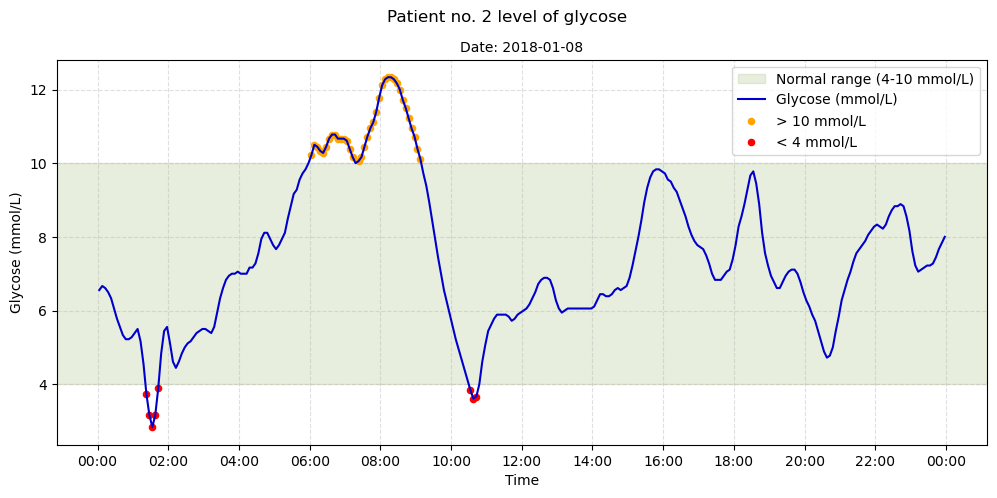

In [ ]:
# A graph about one patient
pt = 2
subset = dclp3[dclp3['PtID'] == pt].iloc[:288]  # with 5-min steps ~ one day worth of data
subset['datetime'] = pd.to_datetime(subset['DataDtTm'])
date = subset['date'].iloc[0]

plt.figure(figsize=(12,5))

# --- In range (4–10 mmol/L)
plt.axhspan(4, 10, color='olivedrab', alpha=0.15, label='Normal range (4-10 mmol/L)')
plt.plot(subset['datetime'], subset['CGM_mmol'], color='mediumblue', label='Glycose (mmol/L)')

# --- Too high: orange dots
plt.scatter(subset['datetime'][subset['CGM_mmol'] > 10],
            subset['CGM_mmol'][subset['CGM_mmol'] > 10],
            color='orange', s=20, label='> 10 mmol/L')

# --- Too low: red dots
plt.scatter(subset['datetime'][subset['CGM_mmol'] < 4],
            subset['CGM_mmol'][subset['CGM_mmol'] < 4],
            color='red', s=20, label='< 4 mmol/L')

plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.suptitle(f'Patient no. {pt} level of glycose')
plt.title(f'Date: {date}', fontsize=10)
plt.xlabel('Time')
plt.ylabel('Glycose (mmol/L)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

In [ ]:
# because the date range varie sby patient
# so we write a function to find the data range with less pain :)
def patient_date_range(ptid):
    subset = dclp3[dclp3["PtID"] == ptid]
    if subset.empty:
        return None
    start = subset["date"].min().strftime("%d.%m.%Y")
    end = subset["date"].max().strftime("%d.%m.%Y")
    return start, end

In [ ]:
patient_date_range(2)

('08.01.2018', '29.07.2018')

Sektordiagramm ühe patsiendi kohta kindlal kuupäeva vahemikul, mil on vahemikus (4...10 mmol/L) ning millla neist piiridest väljas.

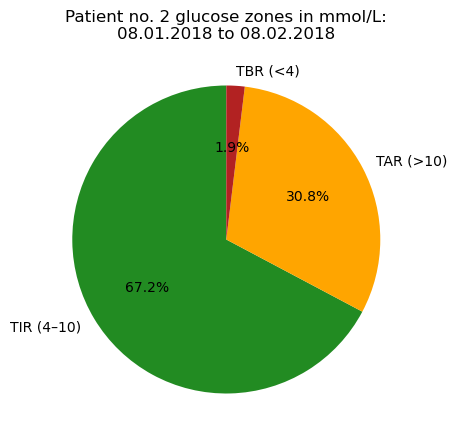

In [ ]:
# Proportions of:
# TBR - Time Below Range
# TIR - Time in Range
# TAR - Time Above Range
# in specific date range on specific patient

pt = 2
start_date = '2018-01-08'
end_date = '2018-02-08'

subset = dclp3[
    (dclp3['PtID'] == pt) &
    (dclp3['date'] >= pd.to_datetime(start_date).date()) &
    (dclp3['date'] <= pd.to_datetime(end_date).date())
].copy()

if subset.empty:
    print(f"Patient no. {pt} has no data between {start_date} -- {end_date}.")
else:
    # Mark the zones; TIR, TAR, and TBR
    subset['zone'] = np.select(
        [subset['CGM_mmol'] < 4,
         subset['CGM_mmol'].between(4, 10),
         subset['CGM_mmol'] > 10],
        ['TBR (<4)', 'TIR (4–10)', 'TAR (>10)'],
        default='missing'
    )

    counts = subset['zone'].value_counts(normalize=True) * 100

    start_date = pd.to_datetime(start_date).strftime("%d.%m.%Y")
    end_date = pd.to_datetime(end_date).strftime("%d.%m.%Y")

    if start_date == end_date:
        date_text = f"{start_date}"
    else:
        date_text = f"{start_date} to {end_date}"

    plt.figure(figsize=(5,5))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%',
            colors=['forestgreen','orange','firebrick','gray'], startangle=90)
    plt.title(f'Patient no. {pt} glucose zones in mmol/L:\n{date_text}')
    plt.show()

Sama info sektordiagrammilt, ent nüüd joontena.

**NB!** Järgnev graafik on implementeeritud ka allpool olevasse suurde koondgraafikusse (kolm joonist iga patsendi kohta tol kuupäevade vahemikus).

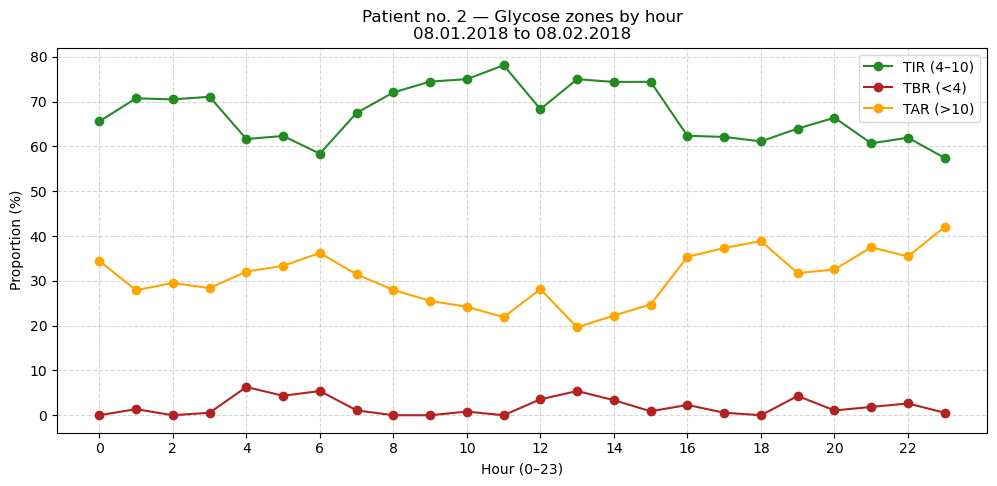

In [ ]:
# Proportions of:
# TBR - Time Below Range
# TIR - Time in Range
# TAR - Time Above Range
# in specific date range

pt = 2
start_date = '2018-01-08'
end_date = '2018-02-08'

subset = dclp3[
    (dclp3['PtID'] == pt) &
    (dclp3['date'] >= pd.to_datetime(start_date).date()) &
    (dclp3['date'] <= pd.to_datetime(end_date).date())
].copy()

if subset.empty:
    print(f"Patient no. {pt} has no data between {start_date} -- {end_date}.")
else:
    subset['zone'] = np.select(
        [subset['CGM_mmol'] < 4,
         subset['CGM_mmol'].between(4, 10),
         subset['CGM_mmol'] > 10],
        ['TBR (<4)', 'TIR (4–10)', 'TAR (>10)'],
        default='missing'
    )

    # Summary by hour
    hourly_summary = (
        subset.groupby('hour')['zone']
        .value_counts(normalize=True)
        .unstack(fill_value=0) * 100
    )

    # Check that all hours from 0 to 23 exist
    for h in range(24):
        if h not in hourly_summary.index:
            hourly_summary.loc[h] = [0,0,0]  # TBR, TIR, TAR
    hourly_summary = hourly_summary.sort_index()

    # Format date appearance
    start_date = pd.to_datetime(start_date).strftime("%d.%m.%Y")
    end_date = pd.to_datetime(end_date).strftime("%d.%m.%Y")

    if start_date == end_date:
        date_text = f"{start_date}"
    else:
        date_text = f"{start_date} to {end_date}"

    # Plotting
    plt.figure(figsize=(12,5))
    plt.plot(hourly_summary.index, hourly_summary.get('TIR (4–10)', 0), marker='o', color='forestgreen', label='TIR (4–10)')
    plt.plot(hourly_summary.index, hourly_summary.get('TBR (<4)', 0), marker='o', color='firebrick', label='TBR (<4)')
    plt.plot(hourly_summary.index, hourly_summary.get('TAR (>10)', 0), marker='o', color='orange', label='TAR (>10)')

    plt.xticks(range(0,24,2))
    plt.xlabel('Hour (0–23)')
    plt.ylabel('Proportion (%)')
    plt.title(f'Patient no. {pt} — Glycose zones by hour\n{date_text}')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

Ühe patsiendi kogu meditsiiiniline ajalugu -- sektordiagramm.

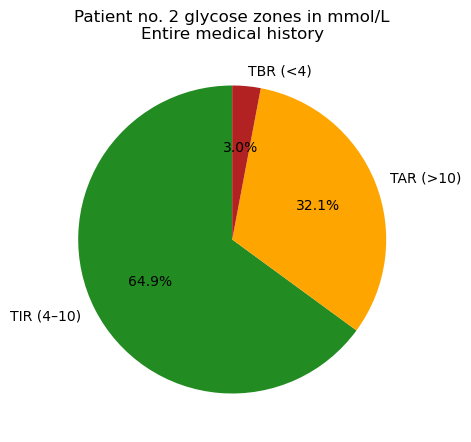

In [ ]:
# Proportions of:
# TBR - Time Below Range
# TIR - Time in Range
# TAR - Time Above Range
# on entire medical history

pt = 2

subset = dclp3[dclp3['PtID'] == pt].copy()

subset['zone'] = np.select(
    [subset['CGM_mmol'] < 4,
     subset['CGM_mmol'].between(4, 10),
     subset['CGM_mmol'] > 10],
    ['TBR (<4)', 'TIR (4–10)', 'TAR (>10)'],
    default='missing'
).astype(object)

counts = subset['zone'].value_counts(normalize=True) * 100

plt.figure(figsize=(5,5))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%',
        colors=["forestgreen",'orange', 'firebrick', 'gray'], startangle=90)
plt.title(f'Patient no. {pt} glycose zones in mmol/L\nEntire medical history')
plt.show()

Ühe patsiendi kogu meditsiiniline ajalugu -- joondiagrammina.

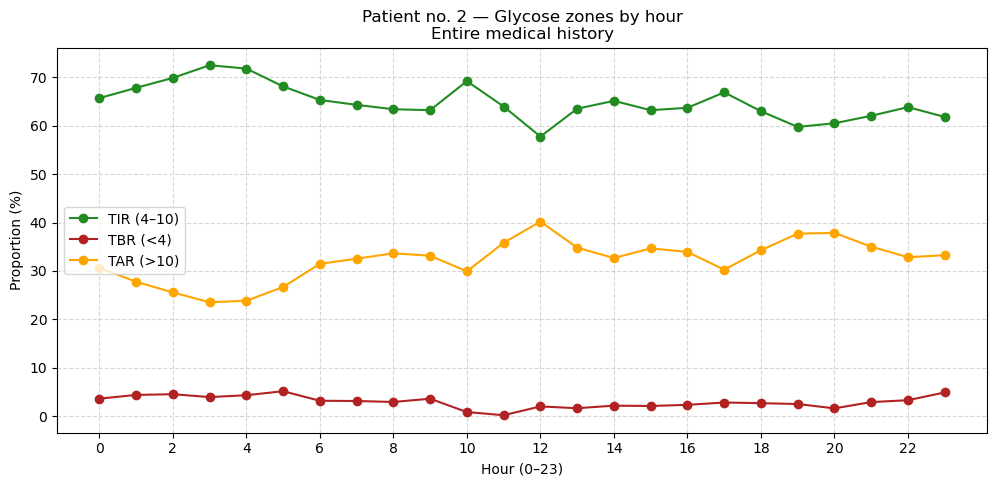

In [ ]:
pt = 2

subset = dclp3[dclp3['PtID'] == pt].copy()

if subset.empty:
    print(f"Patient no. {pt} has no data.")
else:
    subset['hour'] = subset['DataDtTm'].dt.hour

    subset['zone'] = np.select(
        [subset['CGM_mmol'] < 4,
         subset['CGM_mmol'].between(4, 10),
         subset['CGM_mmol'] > 10],
        ['TBR (<4)', 'TIR (4–10)', 'TAR (>10)'],
        default='missing'
    )

    hourly_summary = (
        subset.groupby('hour')['zone']
        .value_counts(normalize=True)
        .unstack(fill_value=0) * 100
    )

    for h in range(24):
        if h not in hourly_summary.index:
            hourly_summary.loc[h] = [0,0,0]
    hourly_summary = hourly_summary.sort_index()

    plt.figure(figsize=(12,5))
    plt.plot(hourly_summary.index, hourly_summary.get('TIR (4–10)', 0), marker='o', color='forestgreen', label='TIR (4–10)')
    plt.plot(hourly_summary.index, hourly_summary.get('TBR (<4)', 0), marker='o', color='firebrick', label='TBR (<4)')
    plt.plot(hourly_summary.index, hourly_summary.get('TAR (>10)', 0), marker='o', color='orange', label='TAR (>10)')

    plt.xticks(range(0,24,2))
    plt.xlabel('Hour (0–23)')
    plt.ylabel('Proportion (%)')
    plt.title(f'Patient no. {pt} — Glycose zones by hour\nEntire medical history')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

In [ ]:
daily = dclp3.groupby(['PtID', 'date'])['CGM'].agg(['mean', 'std', 'min', 'max'])

In [ ]:
dclp3['CGM_mmol_diff'] = dclp3['CGM_mmol'].diff()
dclp3['rolling_mean_mmol'] = dclp3['CGM_mmol'].rolling(window=4, min_periods=1).mean()
dclp3['rolling_std_mmol'] = dclp3['CGM_mmol'].rolling(window=4, min_periods=1).std()
dclp3['delta_from_mean'] = dclp3['CGM_mmol'] - dclp3['rolling_mean_mmol']

In [ ]:
dclp3.head()

,PtID,Period,DataDtTm,CGM,date,time,hour,delta_min,time_period,CGM_mmol,in_range,CGM_category,CGM_mmol_diff,rolling_mean_mmol,rolling_std_mmol,delta_from_mean
0,1,1. Baseline,2017-12-11 23:59:25,172,2017-12-11,23:59:25,23,NaN,21:00–00:00,9.555556,True,in_range,NaN,9.555556,NaN,0.000000
1,1,1. Baseline,2017-12-12 00:04:24,170,2017-12-12,00:04:24,0,4.983333,00:00–03:00,9.444444,True,in_range,-0.111111,9.500000,0.078567,-0.055556
2,1,1. Baseline,2017-12-12 00:09:24,167,2017-12-12,00:09:24,0,5.000000,00:00–03:00,9.277778,True,in_range,-0.166667,9.425926,0.139812,-0.148148
3,1,1. Baseline,2017-12-12 00:14:25,163,2017-12-12,00:14:25,0,5.016667,00:00–03:00,9.055556,True,in_range,-0.222222,9.333333,0.217543,-0.277778
4,1,1. Baseline,2017-12-12 00:19:25,160,2017-12-12,00:19:25,0,5.000000,00:00–03:00,8.888889,True,in_range,-0.166667,9.166667,0.244276,-0.277778


In [ ]:
list(dclp3.columns)

['PtID',
 'Period',
 'DataDtTm',
 'CGM',
 'date',
 'time',
 'hour',
 'delta_min',
 'time_period',
 'CGM_mmol',
 'in_range',
 'CGM_category',
 'CGM_mmol_diff',
 'rolling_mean_mmol',
 'rolling_std_mmol',
 'delta_from_mean']

In [ ]:
print(patient_date_range(1))
print(patient_date_range(2))
print(patient_date_range(3))
print(patient_date_range(4))

('11.12.2017', '02.07.2018')
('08.01.2018', '29.07.2018')
('28.12.2017', '19.07.2018')
('13.08.2017', '24.02.2018')


Järjest patsiendid kindlal kuupäevade vahemikul, kus on toodud ära glükoositaseme kõikumised kogu ajateljel(vertikalane tume kriips tähistab kuupäeva muutust); TIR, TAR ja TBR propotsioonid joondiagrammina ning täpsemalt TBR joondiagramm.

NB! Välja on toodud ka öised hüpoglükeemiad (00-06) ja koidikufenomenid (04-06)!

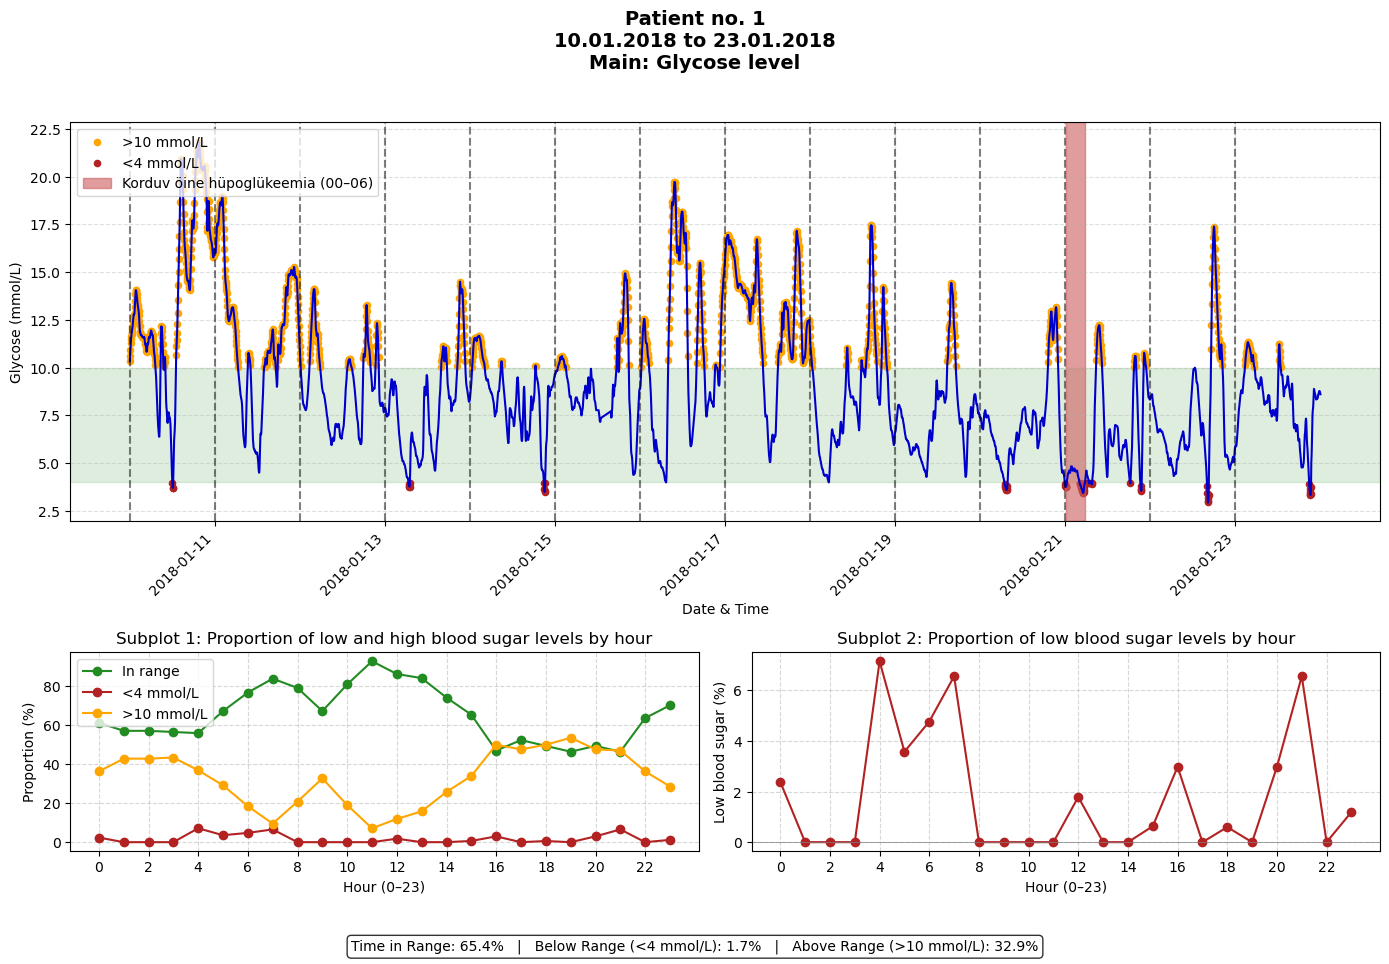

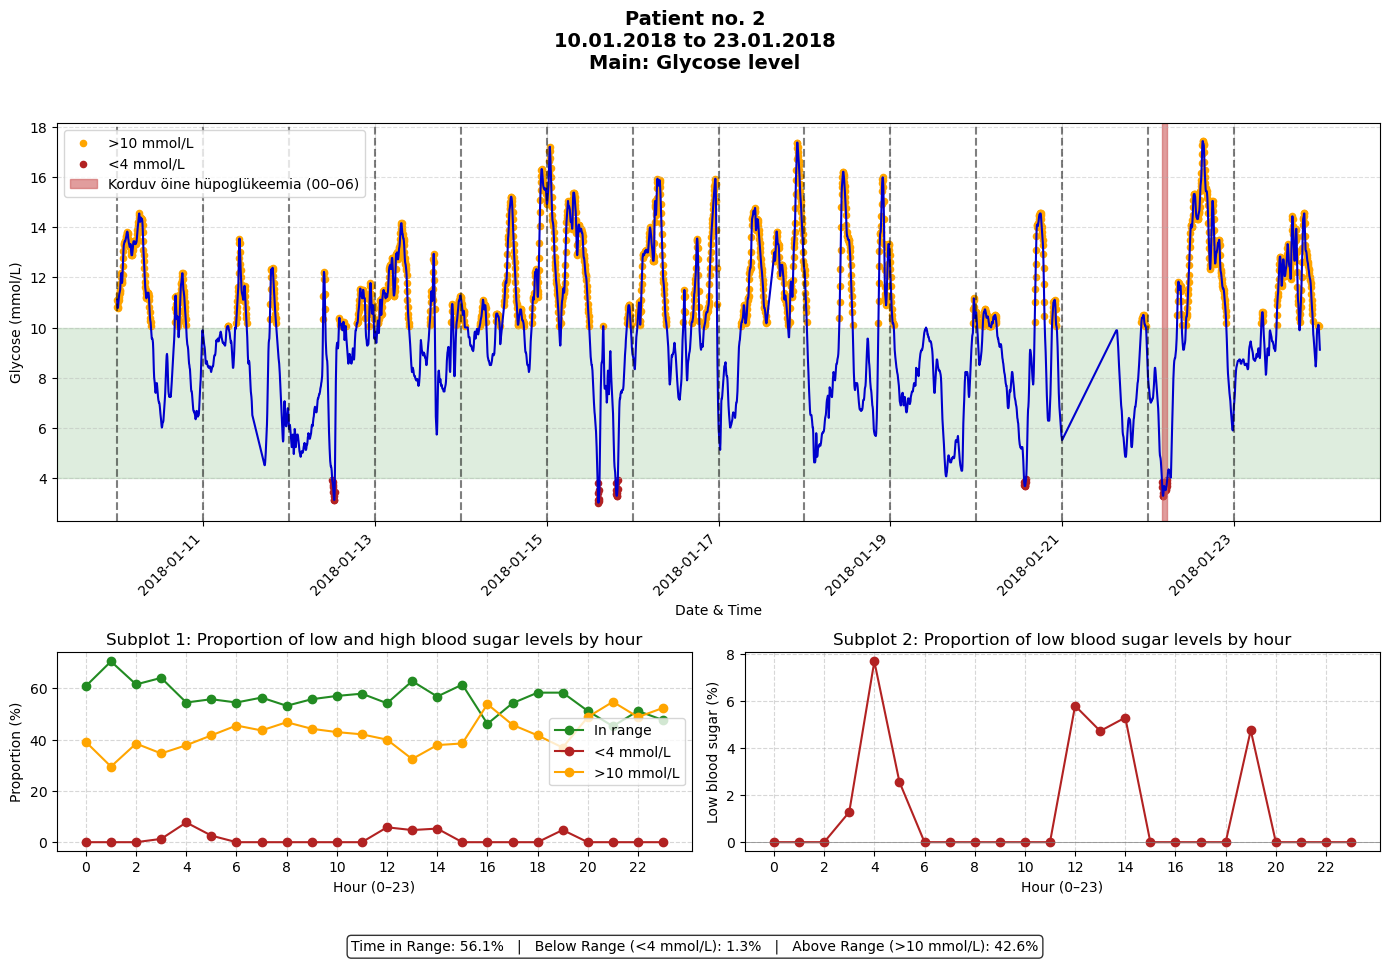

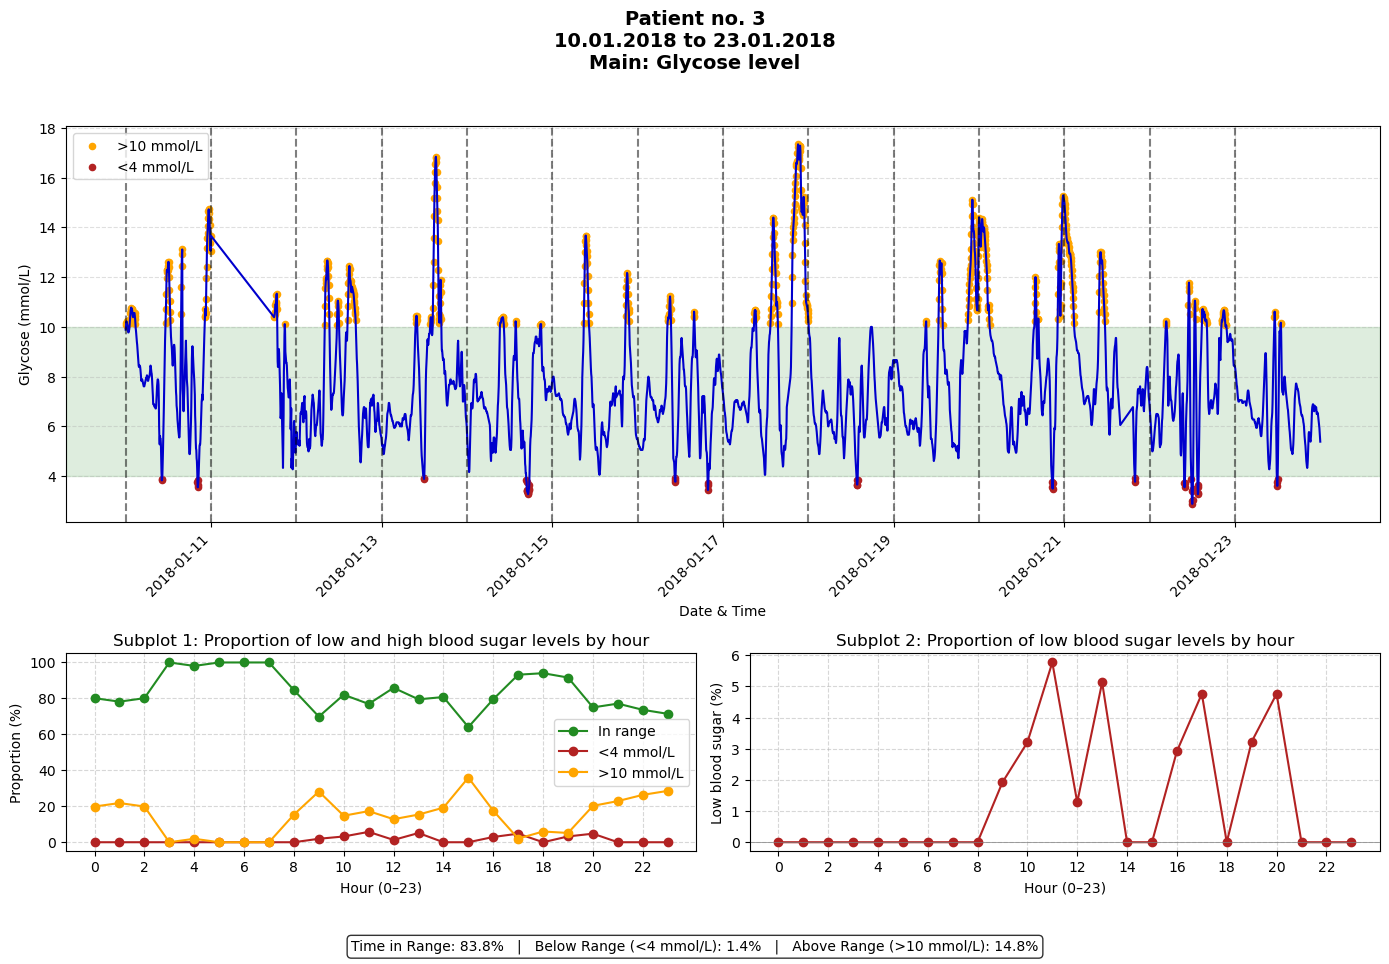

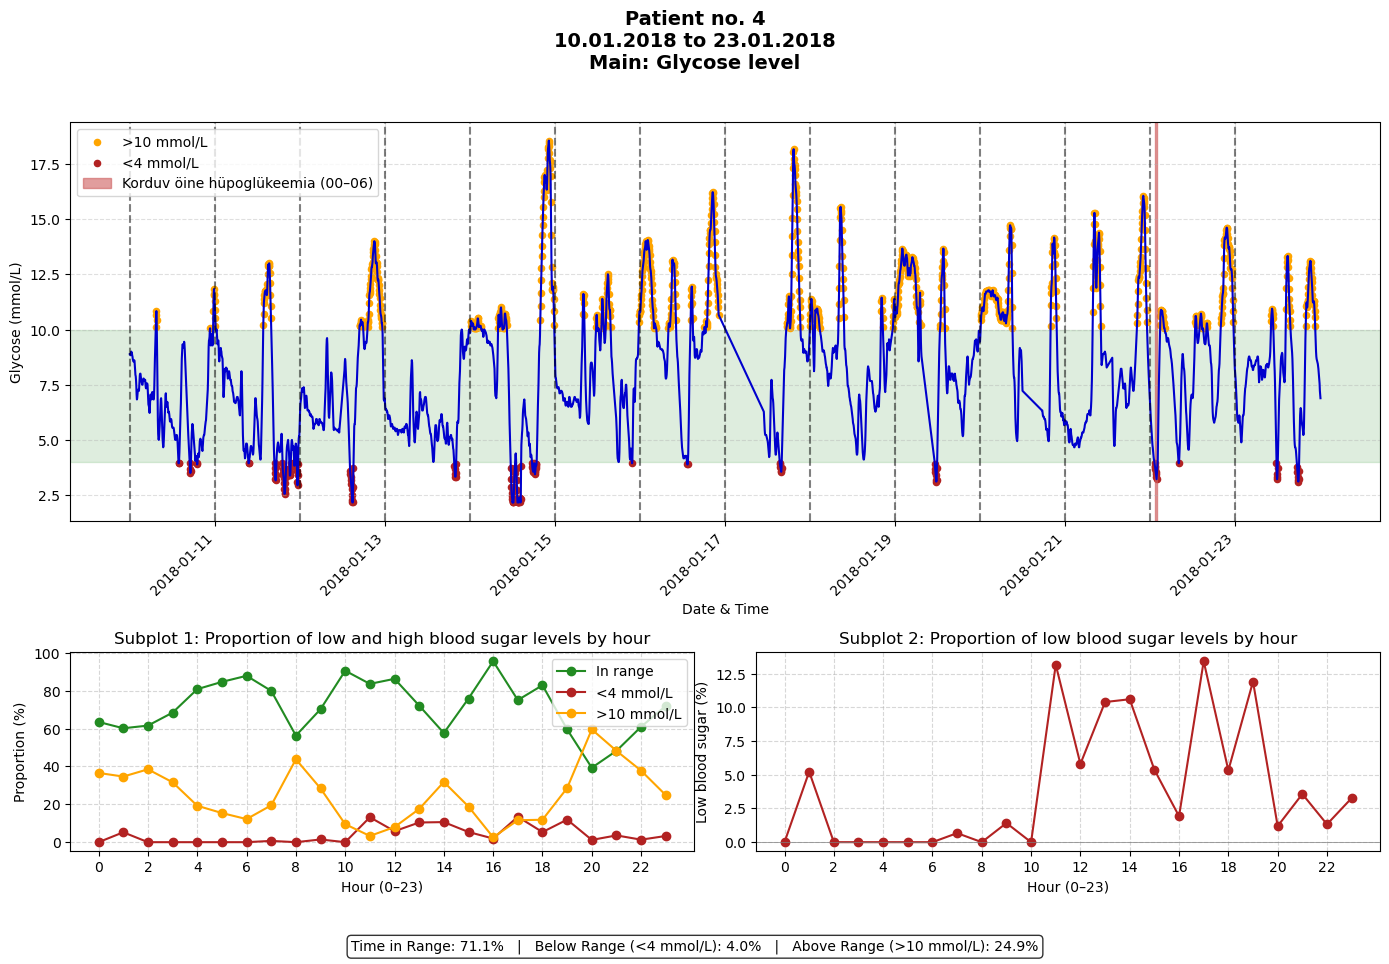

Patient no. 5 has no data between 10.01.2018 -- 23.01.2018.


In [ ]:
# For a range of patients
start_date = '2018-01-10'
end_date = '2018-01-23'

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

for pt in range(1,6):
    subset = dclp3[
        (dclp3['PtID'] == pt) &
        (dclp3['date'] >= start_date.date()) &
        (dclp3['date'] <= end_date.date())
    ].copy()

    if subset.empty:
        print(f"Patient no. {pt} has no data between {start_date:%d.%m.%Y} -- {end_date:%d.%m.%Y}.")
        continue

    subset['hour'] = subset['DataDtTm'].dt.hour

    subset['zone'] = np.select(
        [subset['CGM_mmol'] < 4,
         subset['CGM_mmol'].between(4, 10),
         subset['CGM_mmol'] > 10],
        ['TBR (<4)', 'TIR (4–10)', 'TAR (>10)'],
        default='missing'
    )

    TIR = (subset['CGM_mmol'].between(4,10)).mean() * 100
    TBR = (subset['CGM_mmol'] < 4).mean() * 100
    TAR = (subset['CGM_mmol'] > 10).mean() * 100

    # Summary by hour
    hourly_summary = (
        subset.groupby('hour')['zone']
        .value_counts(normalize=True)
        .unstack(fill_value=0) * 100
    )

    for h in range(24):
        if h not in hourly_summary.index:
            hourly_summary.loc[h] = [0,0,0]
    hourly_summary = hourly_summary.sort_index()

    start_date_str = start_date.strftime("%d.%m.%Y")
    end_date_str = end_date.strftime("%d.%m.%Y")
    date_text = start_date_str if start_date_str == end_date_str else f"{start_date_str} to {end_date_str}"

    fig = plt.figure(figsize=(14,10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])

    ax1 = fig.add_subplot(gs[0, :])
    fig.suptitle(f'Patient no. {pt}\n{date_text}\nMain: Glycose level',
                 fontsize=14, fontweight='bold', y=0.95)

    # Main plot: trends of glycose over time
    ax1.axhspan(4, 10, color='forestgreen', alpha=0.15)
    ax1.plot(subset['DataDtTm'], subset['CGM_mmol'], color='mediumblue')
    ax1.scatter(subset['DataDtTm'][subset['CGM_mmol'] > 10], subset['CGM_mmol'][subset['CGM_mmol'] > 10],
                color='orange', s=20, label='>10 mmol/L')
    ax1.scatter(subset['DataDtTm'][subset['CGM_mmol'] < 4], subset['CGM_mmol'][subset['CGM_mmol'] < 4],
                color='firebrick', s=20, label='<4 mmol/L')

    # Öine hüpoglükeemia (00–06)
    night_hours = range(0,6)
    night_label_added = False

    for d in subset['date'].sort_values().unique():
        day_mask = subset['date'] == d
        night_mask = day_mask & subset['hour'].isin(night_hours) & (subset['CGM_mmol'] < 4)

        if night_mask.any():
            start_time = subset.loc[night_mask, 'DataDtTm'].min()
            end_time   = subset.loc[night_mask, 'DataDtTm'].max()
            label = "Korduv öine hüpoglükeemia (00–06)" if not night_label_added else None
            ax1.axvspan(start_time, end_time, color='indianred', alpha=0.6, label=label)
            night_label_added = True

    # Koidikufenomen (04–08)
    before_hours = range(0,4)
    after_hours  = range(4,9)
    mean_before = subset.loc[subset['hour'].isin(before_hours), 'CGM_mmol']
    mean_after  = subset.loc[subset['hour'].isin(after_hours), 'CGM_mmol']
    if not mean_before.empty and not mean_after.empty:
        if mean_after.mean() - mean_before.mean() > 1.1:  # ~20 mg/dL
            ax1.axvspan(subset['DataDtTm'][subset['hour'].isin(range(4,9))].min(),
                        subset['DataDtTm'][subset['hour'].isin(range(4,9))].max(),
                        color='purple', alpha=0.6, label='Koidikufenomen (04–08)')

    # Separate date change
    for d in subset['date'].sort_values().unique():
        dt_start = pd.to_datetime(d)
        ax1.axvline(dt_start, color='black', linestyle='--', alpha=0.5)

    ax1.set_xlabel('Date & Time')
    ax1.set_ylabel('Glycose (mmol/L)')
    ax1.grid(True, linestyle='--', alpha=0.4)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.legend(loc='upper left')

    # Subplot 1: proportions
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(hourly_summary.index, hourly_summary.get('TIR (4–10)', 0), marker='o', color='forestgreen', label='In range')
    ax2.plot(hourly_summary.index, hourly_summary.get('TBR (<4)', 0), marker='o', color='firebrick', label='<4 mmol/L')
    ax2.plot(hourly_summary.index, hourly_summary.get('TAR (>10)', 0), marker='o', color='orange', label='>10 mmol/L')
    ax2.set_title('Subplot 1: Proportion of low and high blood sugar levels by hour')
    ax2.set_xlabel('Hour (0–23)')
    ax2.set_ylabel('Proportion (%)')
    ax2.set_xticks(range(0,24,2))
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.legend()

    # Subplot 2: low glucose details
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(hourly_summary.index, hourly_summary.get('TBR (<4)', 0), marker='o', color='firebrick', label='<4 mmol/L')
    ax3.axhline(0, color='gray', linewidth=0.5)
    ax3.set_title('Subplot 2: Proportion of low blood sugar levels by hour')
    ax3.set_xlabel('Hour (0–23)')
    ax3.set_ylabel('Low blood sugar (%)')
    ax3.set_xticks(range(0,24,2))
    ax3.grid(True, linestyle='--', alpha=0.5)

    # Info text
    fig.text(0.5, 0.02,
             f"Time in Range: {TIR:.1f}%   |   Below Range (<4 mmol/L): {TBR:.1f}%   |   Above Range (>10 mmol/L): {TAR:.1f}%",
             ha='center', va='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout(rect=[0, 0.05, 1, 0.93])
    plt.show()

Glükoositasemete ajatelje asemel on nüüd x-teljel tunnid (0-23) ja siis KESKMISTATUD glükoositasemetega tunni lõikes. 2. ja 3. joonis on samad mis enne. Phm on nüüd 2. joonis detailsem lahutus 1. joonisest.

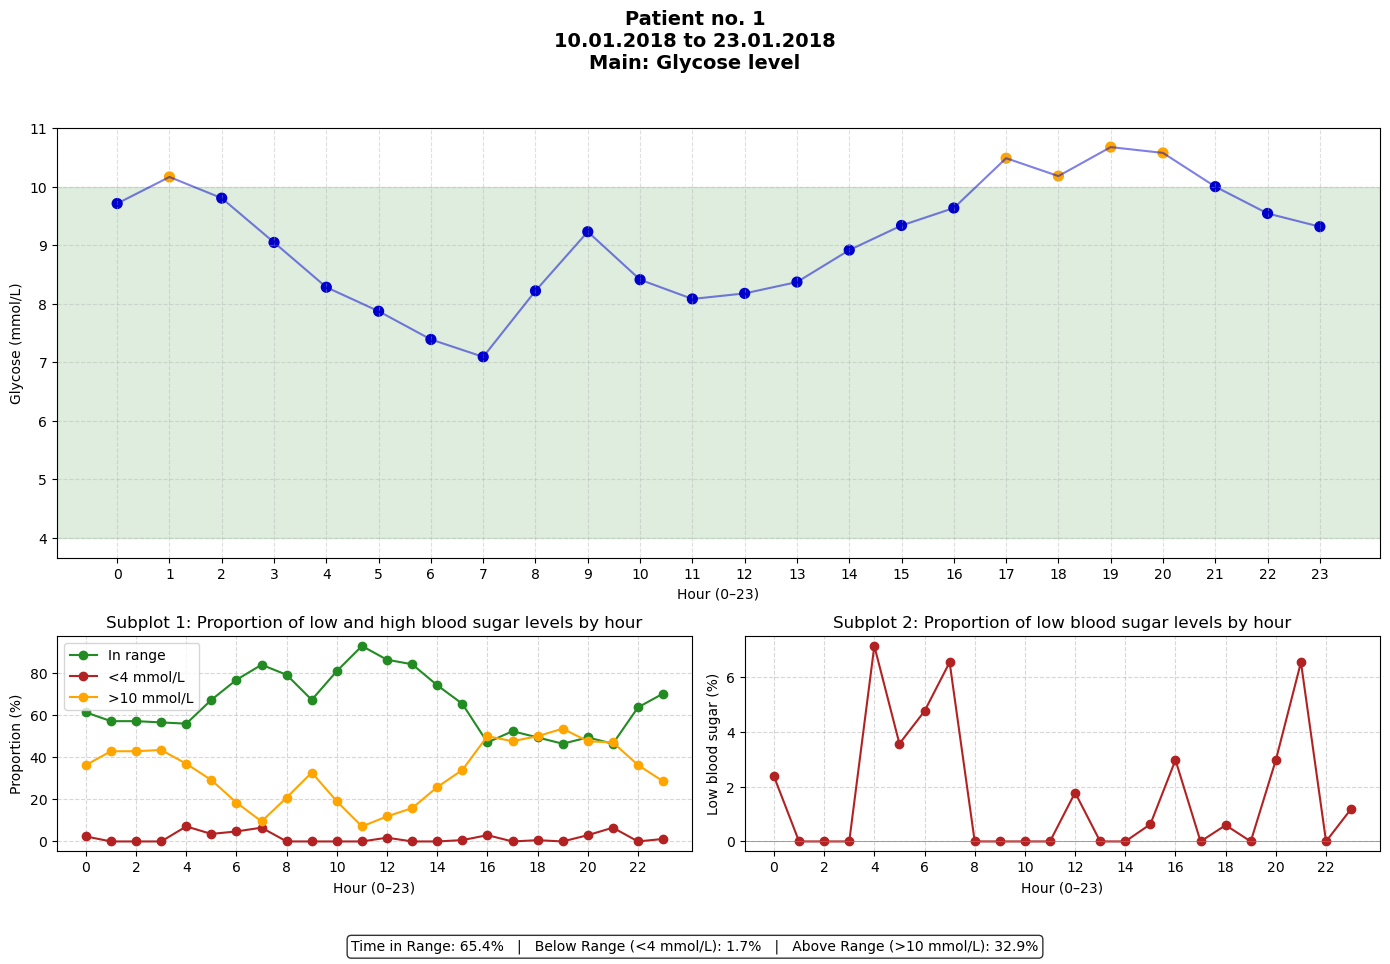

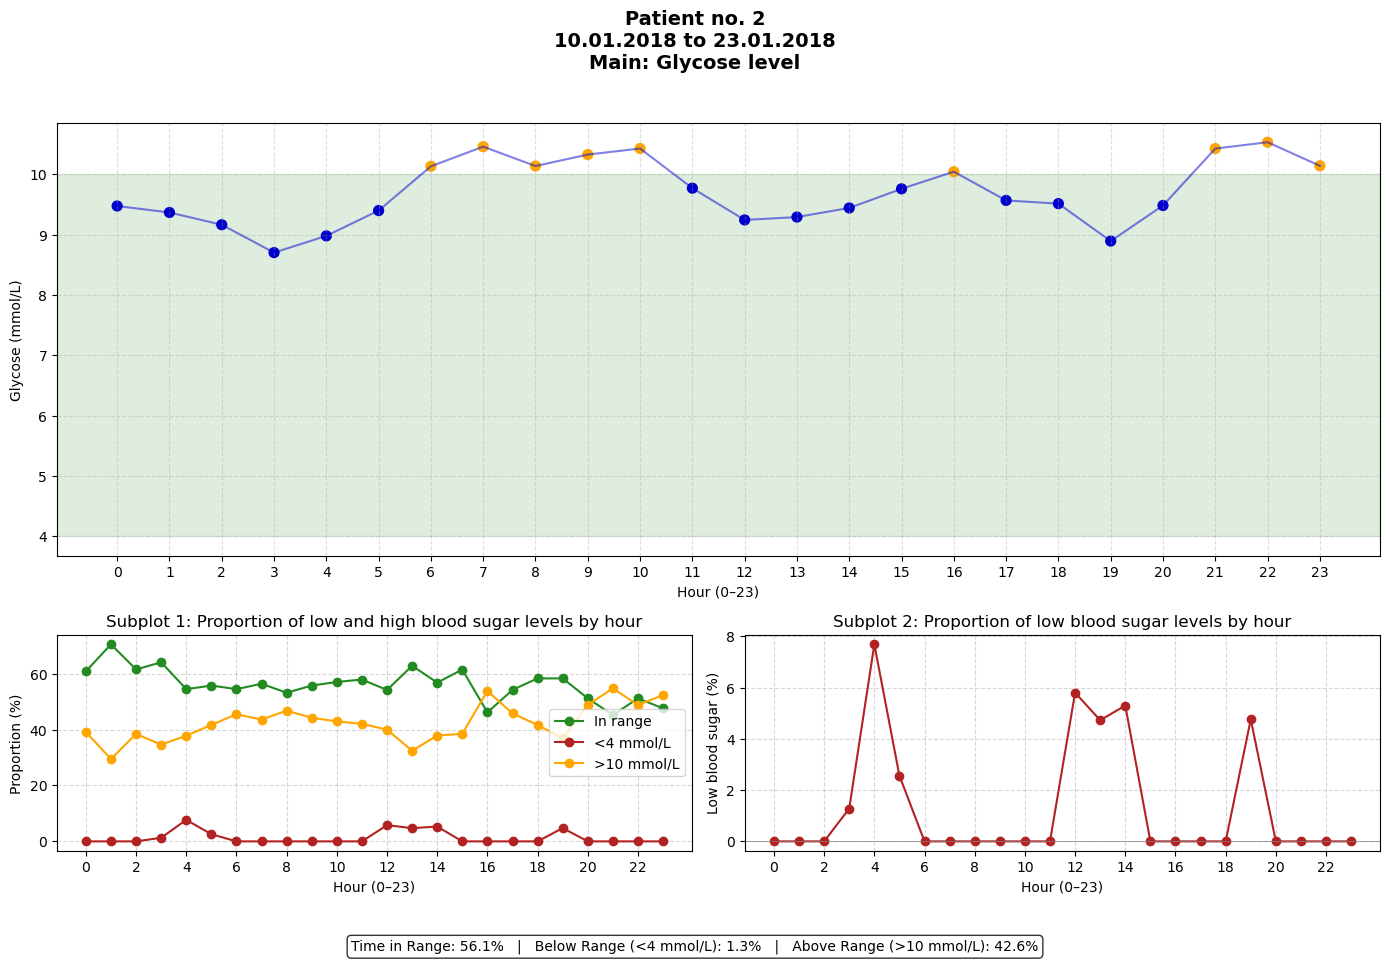

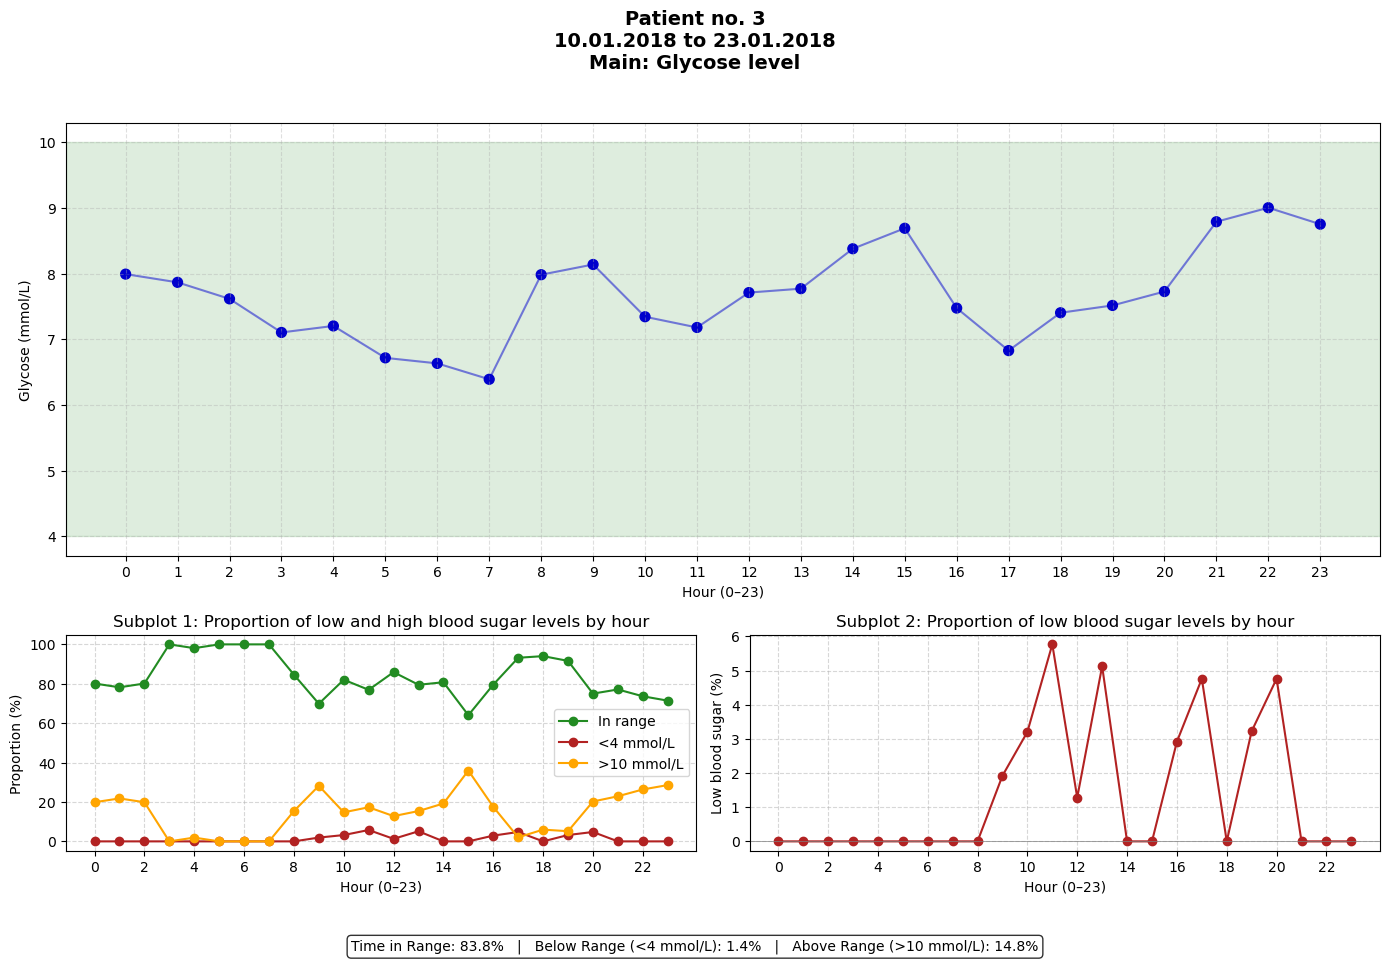

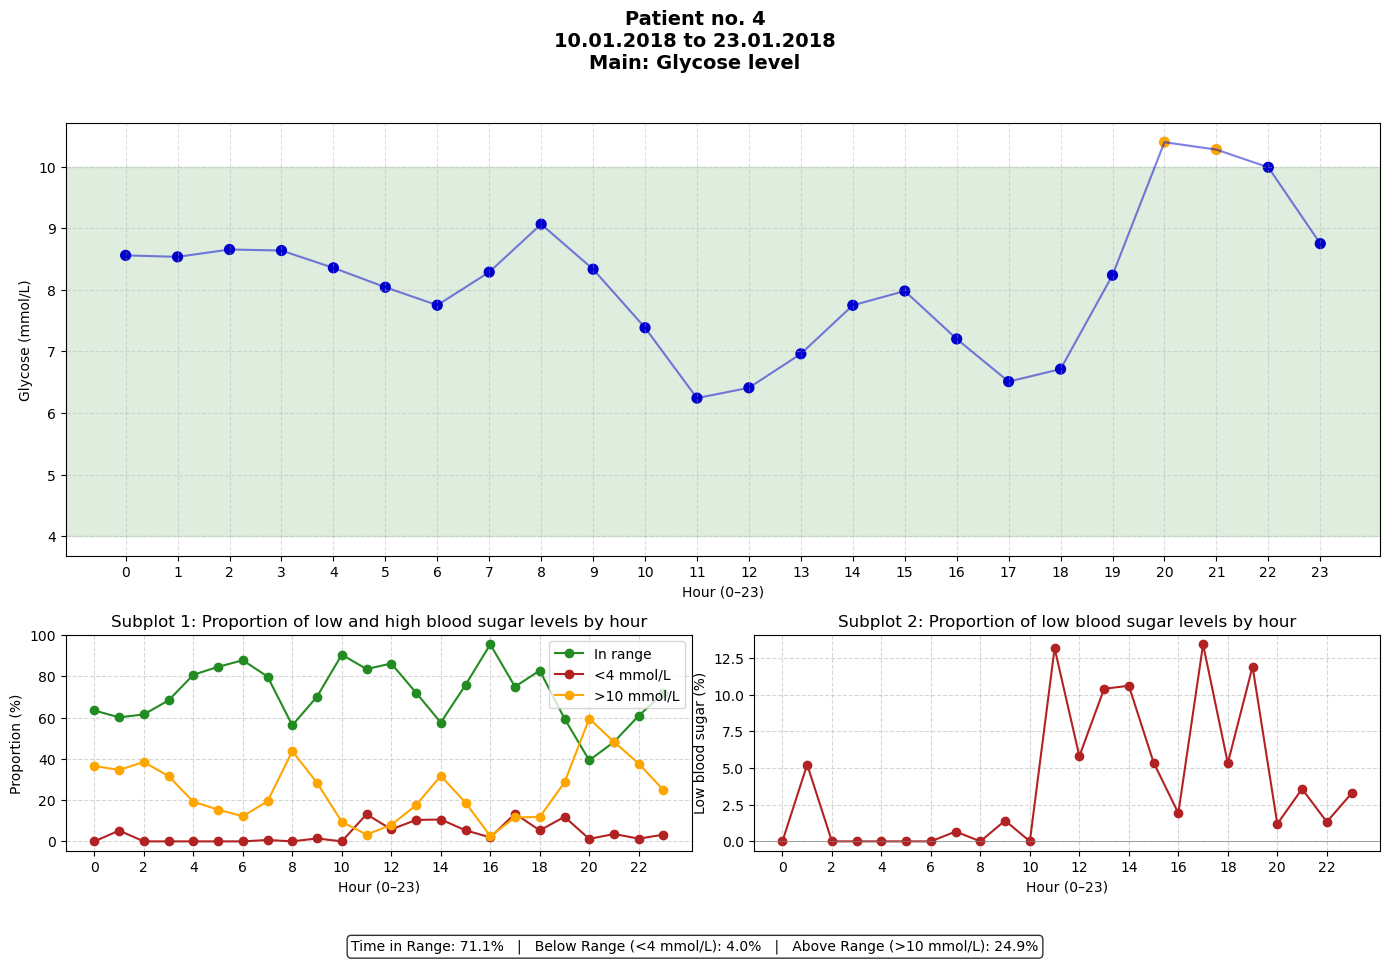

In [ ]:
# For a range of patients
start_date = '2018-01-10'
end_date = '2018-01-23'

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

for pt in range(1,5):
    subset = dclp3[
        (dclp3['PtID'] == pt) &
        (dclp3['date'] >= start_date.date()) &
        (dclp3['date'] <= end_date.date())
    ].copy()

    if subset.empty:
        print(f"Patient no. {pt} has no data between {start_date:%d.%m.%Y} -- {end_date:%d.%m.%Y}.")
        continue

    subset['hour'] = subset['DataDtTm'].dt.hour

    subset['zone'] = np.select(
        [subset['CGM_mmol'] < 4,
         subset['CGM_mmol'].between(4, 10),
         subset['CGM_mmol'] > 10],
        ['TBR (<4)', 'TIR (4–10)', 'TAR (>10)'],
        default='missing'
    )

    TIR = (subset['CGM_mmol'].between(4,10)).mean() * 100
    TBR = (subset['CGM_mmol'] < 4).mean() * 100
    TAR = (subset['CGM_mmol'] > 10).mean() * 100

    # Summary by hour
    hourly_summary = (
        subset.groupby('hour')['zone']
        .value_counts(normalize=True)
        .unstack(fill_value=0) * 100
    )

    # Check that all hours from 0 to 23 exist
    for h in range(24):
        if h not in hourly_summary.index:
            hourly_summary.loc[h] = [0,0,0]
    hourly_summary = hourly_summary.sort_index()

    # Aggregate mean glucose per hour for main plot
    hourly_mean = subset.groupby('hour')['CGM_mmol'].mean()

    # Determine colors based on mean glucose
    colors = ['firebrick' if val < 4 else 'orange' if val > 10 else 'mediumblue'
              for val in hourly_mean.values]

    # Format date appearance
    start_date_str = start_date.strftime("%d.%m.%Y")
    end_date_str = end_date.strftime("%d.%m.%Y")

    if start_date_str == end_date_str:
        date_text = f"{start_date_str}"
    else:
        date_text = f"{start_date_str} to {end_date_str}"

    fig = plt.figure(figsize=(14,10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])

    ax1 = fig.add_subplot(gs[0, :])
    fig.suptitle(f'Patient no. {pt}\n{date_text}\nMain: Glycose level',
                 fontsize=14, fontweight='bold', y=0.95)

    # Main plot: trends of glycose over time (mean per hour)
    ax1.axhspan(4, 10, color='forestgreen', alpha=0.15)
    ax1.scatter(hourly_mean.index, hourly_mean.values, color=colors, s=50, label='Hourly mean glucose')
    ax1.plot(hourly_mean.index, hourly_mean.values, color='mediumblue', alpha=0.5)  # sinine joon
    ax1.set_xlabel('Hour (0–23)')
    ax1.set_ylabel('Glycose (mmol/L)')
    ax1.grid(True, linestyle='--', alpha=0.4)
    ax1.set_xticks(range(0,24,1))

    # Subplot 1:  proportions of low and high blood sugar levels
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(hourly_summary.index, hourly_summary.get('TIR (4–10)', 0), marker='o', color='forestgreen', label='In range')
    ax2.plot(hourly_summary.index, hourly_summary.get('TBR (<4)', 0), marker='o', color='firebrick', label='<4 mmol/L')
    ax2.plot(hourly_summary.index, hourly_summary.get('TAR (>10)', 0), marker='o', color='orange', label='>10 mmol/L')
    ax2.set_title('Subplot 1: Proportion of low and high blood sugar levels by hour')
    ax2.set_xlabel('Hour (0–23)')
    ax2.set_ylabel('Proportion (%)')
    ax2.set_xticks(range(0,24,2))
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.legend()

    # Subplot 2
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(hourly_summary.index, hourly_summary.get('TBR (<4)', 0), marker='o', color='firebrick', label='<4 mmol/L')
    ax3.axhline(0, color='gray', linewidth=0.5)
    ax3.set_title('Subplot 2: Proportion of low blood sugar levels by hour')
    ax3.set_xlabel('Hour (0–23)')
    ax3.set_ylabel('Low blood sugar (%)')
    ax3.set_xticks(range(0,24,2))
    ax3.grid(True, linestyle='--', alpha=0.5)

    # Informational text
    fig.text(0.5, 0.02,
             f"Time in Range: {TIR:.1f}%   |   Below Range (<4 mmol/L): {TBR:.1f}%   |   Above Range (>10 mmol/L): {TAR:.1f}%",
             ha='center', va='top', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout(rect=[0, 0.05, 1, 0.93])
    plt.show()